In [1]:
import modal
import uuid
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import CompiledStateGraph, StateGraph
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.store.postgres import PostgresStore
from langgraph.checkpoint.postgres import PostgresSaver
from dotenv import load_dotenv
import os
from typing import Dict

In [2]:
load_dotenv(override=True)

True

In [3]:
class ChatState(MessagesState):
    model_type: str

In [4]:
from langchain_core.runnables import RunnableConfig
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.checkpoint.postgres import PostgresSaver
from langgraph.store.postgres import PostgresStore  
from langgraph.store.base import BaseStore

## define graph flow

In [5]:
def route_model(state: ChatState) -> str:
    """Route to appropriate model based on selection"""
    if "claude" == state["model_type"].lower():
        return "claude_chat"
    return "gpt_chat"

def gpt_chat_node(state: ChatState) -> ChatState:
    """Handle GPT model calls"""
    model_name = "gpt-5-nano"
    llm = ChatOpenAI(model=model_name, 
                     temperature=0.0, 
                     api_key=os.environ["OPENAI_API_KEY"])
    
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

def claude_chat_node(state: ChatState) -> ChatState:
    """Handle Claude model calls"""
    model_name = "claude-3-5-haiku-latest"
    llm = ChatAnthropic(model=model_name, 
                        temperature=0.0, 
                        api_key=os.environ["CLAUDE_API_KEY"])
    
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

def claude_chat_node(state: ChatState) -> ChatState:
    """Handle Claude model calls"""
    model_name = "claude-3-5-haiku-latest"
    llm = ChatAnthropic(
        model=model_name, 
        temperature=0.0, 
        api_key=os.environ["CLAUDE_API_KEY"]
    )
    logger.info(f"Using Claude model: {os.environ['CLAUDE_API_KEY']}")    
    
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

def create_chat_graph() -> StateGraph:
    """Create the LangGraph workflow"""
    workflow = StateGraph(ChatState)
    
    # Add nodes
    workflow.add_node("gpt_chat", gpt_chat_node)
    workflow.add_node("claude_chat", claude_chat_node)
    
    # Set entry point with conditional routing
    workflow.set_conditional_entry_point(
        route_model,
        {
            "gpt_chat": "gpt_chat",
            "claude_chat": "claude_chat"
        }
    )
    
    # Both end after processing
    workflow.add_edge("gpt_chat", END)
    workflow.add_edge("claude_chat", END)

    return workflow

In [6]:
from IPython.display import Image, display
# persistent postgres storage 
DB_URI = os.environ["SUPABASE_DB_URL"]
# define session_id 
session_id = str(uuid.uuid4())
# define user for testing 
user_id = "test_user"
test_result = None

In [7]:
def chat(data: Dict) -> Dict:
    message = data.get("message")
    model_type = data.get("model", "gpt")
    session_id = data.get("session_id")
    user_id = data.get("user_id")
    if not user_id:
        return {
            "error": "no user id",
            "status": "error",
        },400

    if not message:
        return {
            "error": "no messages provided",
            "status": "error",
        }, 400

    if not session_id:
        return {
            "error": "no session id",
            "status": "error",
        },400
    try:

        config = {"configurable": {"thread_id": session_id, "user_id": user_id}}

        input_state = {
            "messages": [
                HumanMessage(content=message)],
            "model_type": model_type
        }
        with (
             PostgresStore.from_conn_string(DB_URI) as store,  
             PostgresSaver.from_conn_string(DB_URI) as checkpointer,
            ):
                 compiled_graph = create_chat_graph().compile(
                     checkpointer=checkpointer,
                     store=store,  
                 )
                 graph_structure = compiled_graph.get_graph()
                 display(Image(graph_structure.draw_mermaid_png()))
                 
                 store.put((user_id, session_id), str(uuid.uuid4()), {"data": message})  
                 result = compiled_graph.invoke(input_state, config)
                 
                 last_message = result["messages"][-1]
                 test_result = result
                 return {
                    "message": last_message.content,
                    "session_id": session_id,
                    "user_id": user_id,
                    "model": model_type,
                    "conversation_length": len(result["messages"]),
                    "status": "success"
                }
    except Exception as e:
        return {
            "error": "ran into unexpected issues during chatting",
            "detail": e,
            "status": "error"
        }, 500        

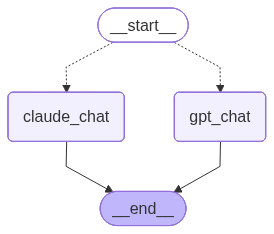

In [8]:
result = chat(data={"model_type": "claude", "message": "What are the four personality colors?", "session_id": session_id, "user_id": user_id})

In [9]:
result

{'message': 'There are a few popular four-color personality systems, but the most common colors are:\n\n- Red\n- Yellow\n- Green\n- Blue\n\nA common, high-level mapping (varies by model):\n- Red: bold, decisive, task-focused\n- Yellow: social, enthusiastic, imaginative\n- Green: supportive, patient, reliable\n- Blue: analytical, precise, organized\n\nNote: different frameworks map these colors to traits in slightly different ways (for example, DISC uses Red=Dominance, Yellow=Influence, Green=Steadiness, Blue=Conscientiousness). If you tell me which model you’re using (DISC, Insights, True Colors, etc.), I can give the exact descriptions for that system.',
 'session_id': '1247e01e-d309-4ab4-bc58-bd1e5d15adc9',
 'user_id': 'test_user',
 'model': 'gpt',
 'conversation_length': 2,
 'status': 'success'}

In [10]:
session_id

'1247e01e-d309-4ab4-bc58-bd1e5d15adc9'

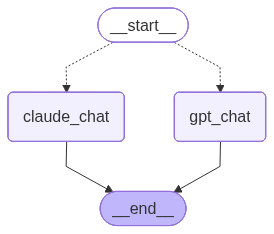

In [11]:
result = chat(data={"message": "I think I am color red, what about you?", "session_id": session_id, "user_id": user_id})

In [12]:
result

{'message': 'Nice—red personality tends to be bold, decisive, and task-focused.\n\nI don’t have a personal color, but I can adapt to your style. If you want, I can reply in a red-style: concise, direct, with clear actions and deadlines. Or I can switch to another style anytime.\n\nWant me to respond in red-style going forward? If you give me a task, I’ll lay out a simple plan with concrete steps and a timeline.',
 'session_id': '1247e01e-d309-4ab4-bc58-bd1e5d15adc9',
 'user_id': 'test_user',
 'model': 'gpt',
 'conversation_length': 4,
 'status': 'success'}

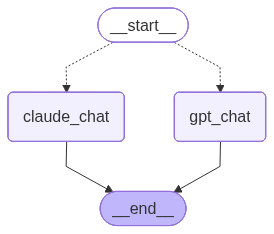

In [ ]:
result = chat(data={"message": "What personality type I think I am?", "session_id": session_id, "user_id": user_id})

In [ ]:
result

## Get history via checkpoint

In [ ]:
def get_history(data: Dict):
    """
    Get conversation history for a session
    
    Example request:
    {
        "session_id": "user-123"
    }
    """
    session_id = data.get("session_id")
    
    if not session_id:
        return {
            "error": "No session_id provided",
            "status": "error"
        }, 400
    
    try:
        message_history = None
        with PostgresSaver.from_conn_string(DB_URI) as checkpointer:
            read_config = {"configurable": {"thread_id":session_id}}
            checkpointer.get(read_config)
            message_history = list(checkpointer.list(read_config))

        all_messages = message_history[0].checkpoint["channel_values"]["messages"]
        formatted_messages = []
        for msg in all_messages:
            if isinstance(msg, HumanMessage):
                formatted_messages.append({"role": "user", "content": msg.content})
            elif isinstance(msg, AIMessage):
                formatted_messages.append({"role": "assistant", "content": msg.content})
            elif isinstance(msg, SystemMessage):
                formatted_messages.append({"role": "system", "content": msg.content})
        
        return {
            "messages": formatted_messages,
            "session_id": session_id,
            "conversation_length": len(formatted_messages),
            "status": "success"
        }
        
    except Exception as e:
        return {
            "error": str(e),
            "status": "error"
        }, 500

In [ ]:
get_history(data = {"session_id": session_id})

In [ ]:
def get_stored_context(data: Dict, query:str="", limit:int=3) -> str:
    session_id = data.get("session_id")
    user_id = data.get("user_id")
    if session_id is None:
        raise ValueError("No session id provided")
    if user_id is None:
        raise ValueError("No user id provided")
    store_history = None
    with PostgresStore.from_conn_string(DB_URI) as store:
        store_history = store.search((user_id, session_id), query=query, limit=limit)

    context = []
    for history in store_history:
        context.append(history.value["data"])

    return "\n".join(context)
        

In [ ]:
get_stored_context({"user_id": user_id, "session_id": session_id}, query="red", limit=1)

In [ ]:
def clear_history(data: Dict):
    """
    Clear conversation history for a session
    
    Example request:
    {
        "session_id": "user-123"
    }
    """
    session_id = data.get("session_id")
    
    if not session_id:
        return {
            "error": "No session_id provided",
            "status": "error"
        }, 400
    
    try:
        with PostgresSaver.from_conn_string(DB_URI) as checkpointer:
            checkpointer.delete_thread(thread_id = session_id)
        
        return {
            "message": "History cleared",
            "session_id": session_id,
            "status": "success"
        }
        
    except Exception as e:
        return {
            "error": str(e),
            "status": "error"
        }, 500

In [ ]:
def clear_store(data: Dict) -> Dict:
    session_id = data.get("session_id")
    user_id = data.get("user_id")

    if not user_id:
        return {
            "error": "No user_id provided",
            "status": "error"
        }, 400
    
    if not session_id:
        return {
            "error": "No session_id provided",
            "status": "error"
        }, 400
    
    try:
        with PostgresStore.from_conn_string(DB_URI) as store:
            items = store.search((user_id, session_id))
            for item in items:
                store.delete(namespace=(user_id, session_id), key=item.key)
        
        return {
            "message": "History cleared",
            "session_id": session_id,
            "user_id": user_id,
            "status": "success"
        }
        
    except Exception as e:
        return {
            "error": str(e),
            "status": "error"
        }, 500
    

In [ ]:
clear_store(data={"user_id": user_id, "session_id": "33ca71e9-127f-445d-b2eb-9e62910c82ef"})

In [ ]:
session_id

In [ ]:
clear_history(data={"session_id": "99cab2fb-8d58-4248-b3a4-5687b9d41abd"})